In [1]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath("./../plots") + "/"

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp
import importlib
importlib.reload(rhp)

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)

##################

fits_path_36 = spec_dir+'order36/jun02s*'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_fits(path=fits_path_36)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
    
        spec36_reducelist.append(reduce_spec36)
        
spec36_reduced = np.array(spec36_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R = R36


modeA36 = order36_data[104-int0] + order36_data[107-int0] +\
        order36_data[108-int0] + order36_data[111-int0]
modeB36 = order36_data[105-int0] + order36_data[106-int0] +\
        order36_data[109-int0] + order36_data[110-int0]

exp_star = 25

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

flux36_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.003, min=0, max=0.01)
flux36_params.add('a1', value=36)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

lower = 0
upper = 1024

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

spat_ax36 = np.linspace(0, modeAB36.shape[0]-1, modeAB36.shape[0])

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

Fc36 = Fbb36/Fobs36

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

slit_pix_scale = 0.288
wave_pix_scale_36 = 2.908e-5

slit_area36 = slit_pix_scale * width36 * wave_pix_scale_36 * length36

exp_spec = 60

fjc36_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    
fjc36 = np.array(fjc36_list)

RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

star36_median = np.mean((modeAB36.T[200:800,20:220]), axis=0)

pix_diff_star36 = np.where(star36_median==np.min(star36_median))[0][0] - np.where(star36_median==np.max(star36_median))[0][0]

zoom_fac36 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star36

fjc36_rs = ndimage.zoom(fjc36, [1,zoom_fac36,1], mode='nearest')

# fjc36_rs = np.delete(fjc36_rs, np.s_[260:], 1)

Text(0.5, 1.0, 'Order 36')

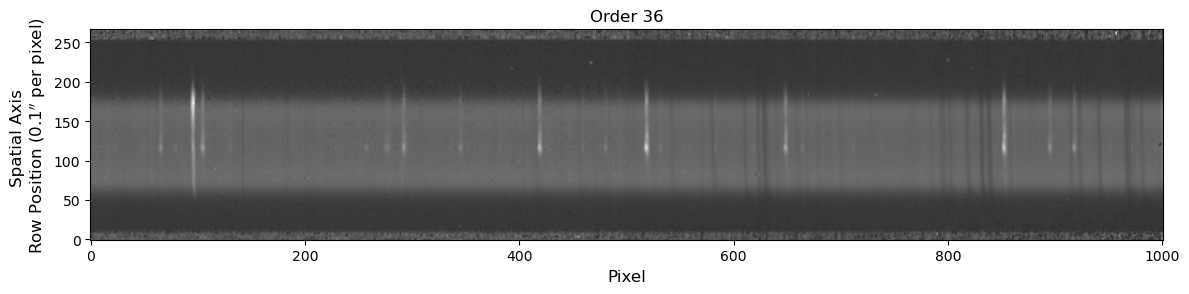

In [2]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc36_rs[1][:,:1001],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 36', fontsize=12)

Text(0.5, 1.0, 'Order 36')

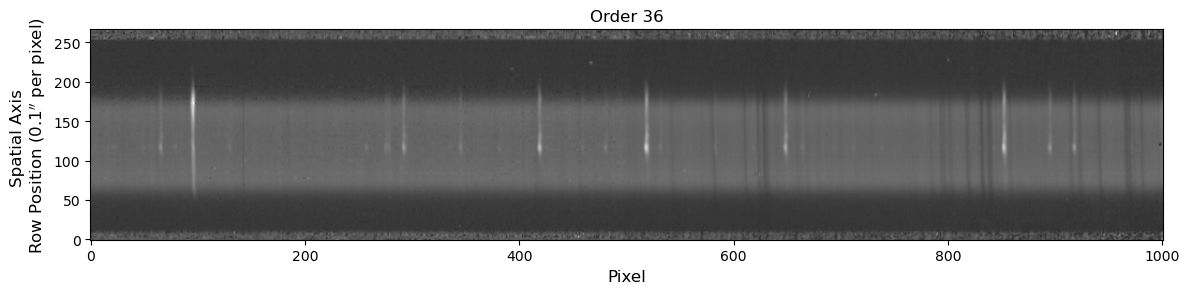

In [19]:
spec36_h2 = np.concatenate((fjc36_rs[1][:,:101],fjc36_rs[1][:,189:201], fjc36_rs[1][:,113:1001]), axis=1)
wave36_h2 = waverange36[:1001]

fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec36_h2,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')

plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 36', fontsize=12)

Text(0.5, 0, 'Pixel')

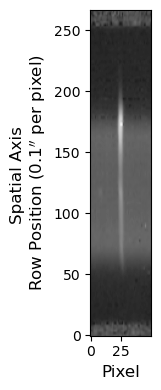

In [20]:
fig = plt.figure(figsize=(5,4), tight_layout=True)

fig.add_subplot(131)
plt.imshow(spec36_h2[:,71:121],
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

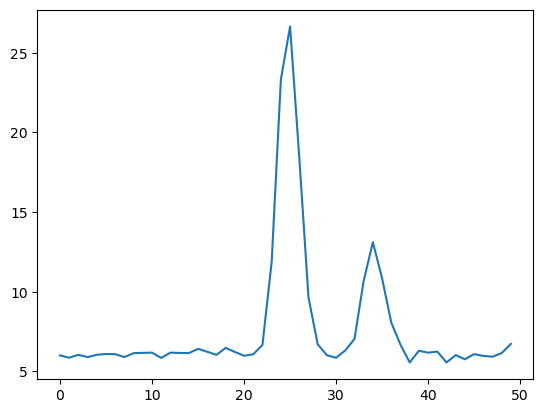

In [23]:
plt.plot(fjc36_rs[17][:,71:121][140] * 1e3)

In [24]:
st_list = []

for i in range(len(fjc36_rs)):
    spec36_h2 = np.concatenate((fjc36_rs[i][:,:101],fjc36_rs[i][:,189:201], fjc36_rs[i][:,113:1001]), axis=1)

    s1b = ndimage.shift(spec36_h2[:,71:121], [0,0.290495], order=3, mode='nearest')
    
    st_list.append(s1b)

st = np.array(st_list)

for i in range(len(st)):
    a = st[i][170][:]
    b = st[i][171][:]
    c = st[i][175][:]
    d = st[i][176][:]
    f = np.median((a, b, c, d), axis=0)
    st[i][172][:] = f * 1
    st[i][173][:] = f * 1
    st[i][174][:] = f * 1

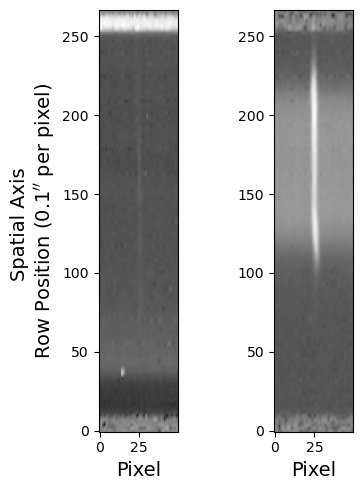

In [29]:
spt = st[17]
x = waverange36[0:1001]

fig = plt.figure(figsize=(5,5), tight_layout=True)

fig.add_subplot(121)
plt.imshow(spec36_h2[:,71:121],
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.xlabel('Pixel', fontsize=14)

fig.add_subplot(122)
plt.imshow(spt, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
# plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
# plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.xlabel('Pixel', fontsize=14)
plt.ticklabel_format(useOffset=False)
# plt.title('a) Order 35 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
# plt.gca().invert_yaxis()

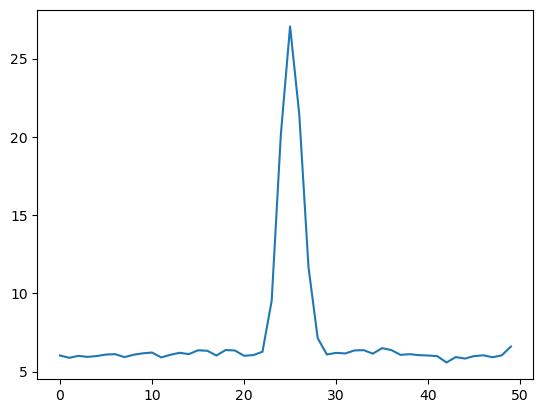

In [30]:
plt.plot(spt[140] * 1e3)

In [9]:
# extract H3+ properties by fitting gaussian curve to the emission lines
h2_a0_map = []
h2_a1_map = []
h2_fwhm_map = []
h2_a0_map_error = []
h2_a1_map_error = []
h2_fwhm_map_error = []


fn0 = 0
fn1 = np.size(st,0)

upper_h2 = 240
lower_h2 = 30

print('h2 LOOP START')
for fn in range(fn0, fn1):
    print('Frame Number = ' + str(fn))

    h2_a0 = np.zeros(301)
    h2_a1 = np.zeros(301)
    h2_a2 = np.zeros(301)
    h2_a0_error = np.zeros(301)
    h2_a1_error = np.zeros(301)
    h2_a2_error = np.zeros(301)
    
    stack = st[fn]
    
    pixel = np.linspace(0, np.size(stack,1)-1, np.size(stack,1))
    
    for i in range(lower_h2, upper_h2):
        # create lmfit model with defined gaussian
        h2_model = Model(rhp.gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.03, min=0, max=0.5)
        h2_params.add('a1', value=25, min=22, max=28)
        h2_params.add('a2', value=2, min=0, max=6)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
        
        # perform gaussian fit and test errors
        try:
            h2_fit_result = h2_model.fit(stack[i], h2_params, x=pixel)
        except ValueError:
            print('ValueError occured at i=' + str(i))
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, stack[i])
            plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
        
        # collect fitting parameters
        h2_a0[i] = h2_fit_result.params['a0'].value
        h2_a1[i] = h2_fit_result.params['a1'].value
        h2_a2[i] = h2_fit_result.params['a2'].value
        h2_a0_error[i] = h2_fit_result.params['a0'].stderr
        h2_a1_error[i] = h2_fit_result.params['a1'].stderr
        h2_a2_error[i] = h2_fit_result.params['a2'].stderr
        
    # collect fitting parameters of each frame number and calibrate errors
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_fwhm_map.append(h2_a2 * (np.sqrt(2*np.log(2))*2))
    
    h2_a0_error[h2_a0_error > 10] = 1e10
    h2_a0_error[np.isnan(h2_a0_error)] = 1e10
    h2_a0_map_error.append(h2_a0_error)
    
    
    h2_a1_error[h2_a1_error > 10] = 1e10
    h2_a1_error[np.isnan(h2_a1_error)] = 1e10
    h2_a1_map_error.append(h2_a1_error)
    
    h2_a2_error[h2_a2_error > 10] = 1e10
    h2_a2_error[np.isnan(h2_a2_error)] = 1e10  
    h2_fwhm_map_error.append(h2_a2_error * (np.sqrt(2*np.log(2))*2))
    
print('DONE')

h2 LOOP START
Frame Number = 0
Frame Number = 1
Frame Number = 2
Frame Number = 3
Frame Number = 4
Frame Number = 5
Frame Number = 6
Frame Number = 7
Frame Number = 8
Frame Number = 9
Frame Number = 10
Frame Number = 11
Frame Number = 12
Frame Number = 13
Frame Number = 14
Frame Number = 15
Frame Number = 16
Frame Number = 17
Frame Number = 18
Frame Number = 19
Frame Number = 20
Frame Number = 21
Frame Number = 22
Frame Number = 23
Frame Number = 24
Frame Number = 25
Frame Number = 26
Frame Number = 27
Frame Number = 28
Frame Number = 29
Frame Number = 30
Frame Number = 31
Frame Number = 32
Frame Number = 33
Frame Number = 34
Frame Number = 35
Frame Number = 36
Frame Number = 37
DONE


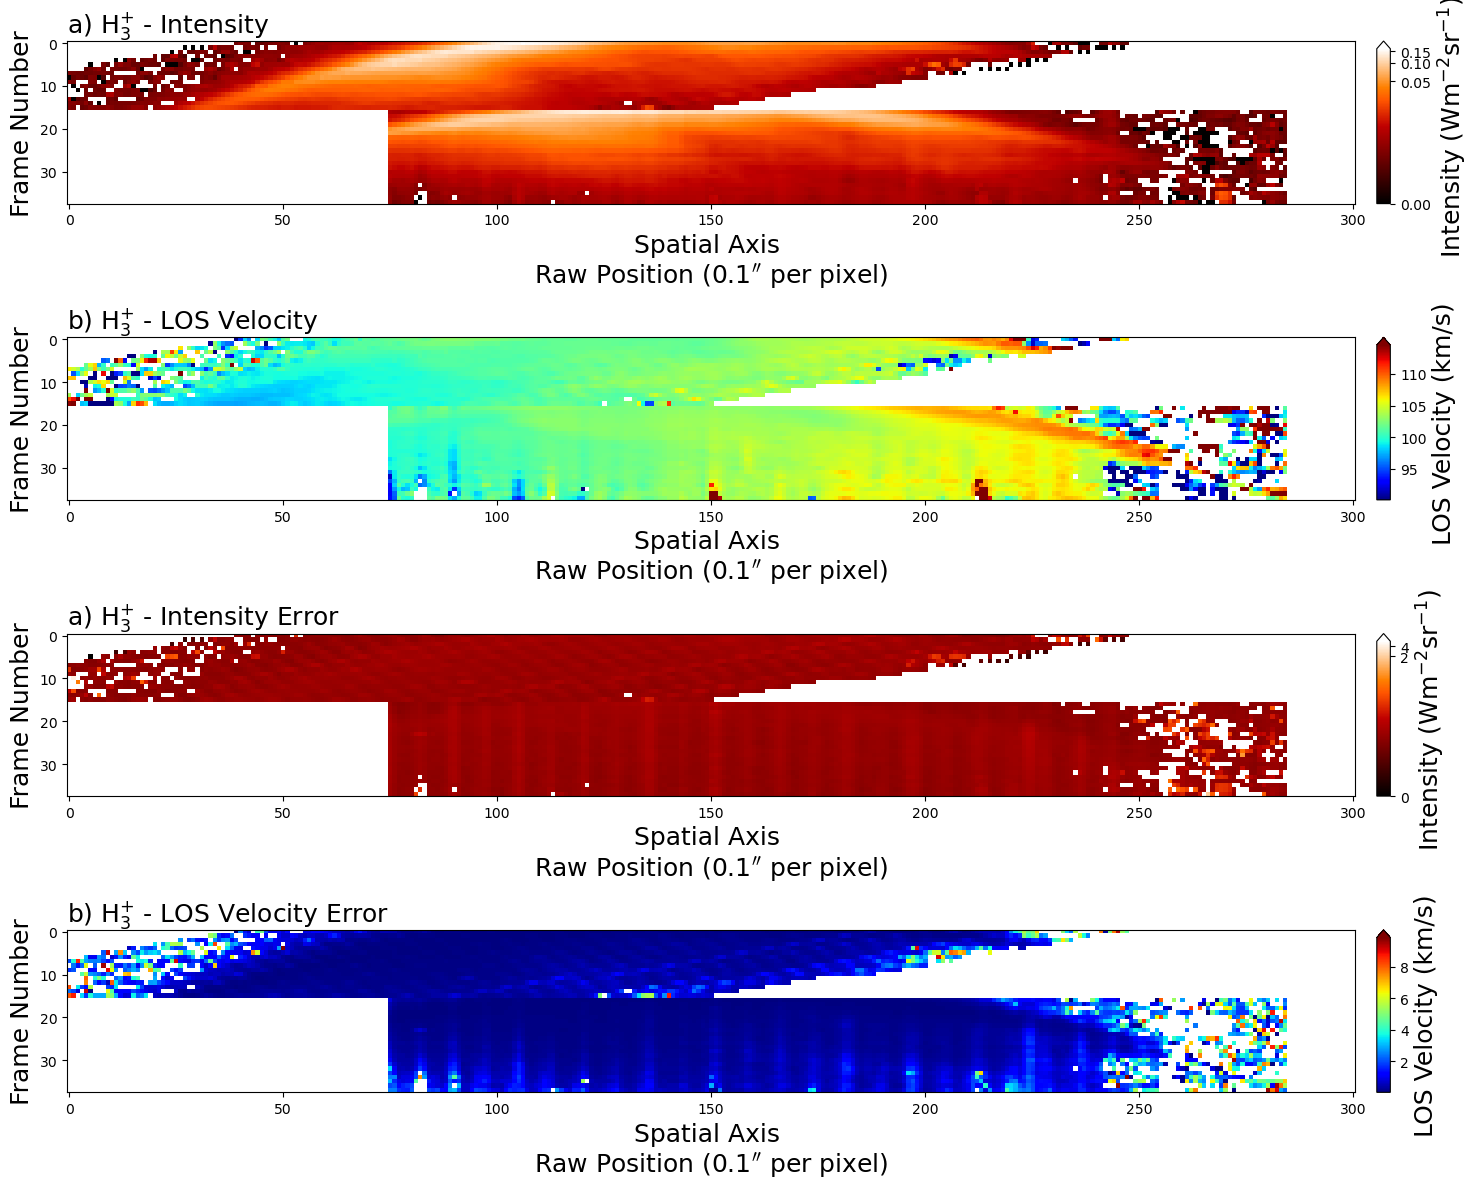

In [12]:
# data
h2_a0 = np.vstack((h2_a0_map))
h2_a1 = np.vstack((h2_a1_map))
h2_fwhm = np.vstack((h2_fwhm_map))

h2_int = h2_a0*h2_fwhm
h2_los = h2_a1/R*3e5*np.cos(3.098*np.pi/180)

h2_int1 = np.roll(h2_int[:6], 23, axis=1)
h2_int2 = np.roll(h2_int[6:11], 22, axis=1)
h2_int3 = np.roll(h2_int[11:16], 30, axis=1)
h2_int4 = np.roll(h2_int[16:27], -14, axis=1)
h2_int5 = np.roll(h2_int[27:], -14, axis=1)
h2_int_shifted = np.vstack((h2_int1, h2_int2, h2_int3, h2_int4, h2_int5))

for i in range(16):
    h2_int_shifted[i,:] = ndimage.shift(h2_int_shifted[i,:], i*6, order=5)

    
h2_los1 = np.roll(h2_los[:6], 23, axis=1)
h2_los2 = np.roll(h2_los[6:11], 22, axis=1)
h2_los3 = np.roll(h2_los[11:16], 30, axis=1)
h2_los4 = np.roll(h2_los[16:27], -14, axis=1)
h2_los5 = np.roll(h2_los[27:], -14, axis=1)
h2_los_shifted = np.vstack((h2_los1, h2_los2, h2_los3, h2_los4, h2_los5))

for i in range(16):
    h2_los_shifted[i,:] = ndimage.shift(h2_los_shifted[i,:], i*6, order=5)

h2_int_shifted = np.flip(h2_int_shifted, 1)
h2_los_shifted = np.flip(h2_los_shifted, 1)

# error
h2_a0_error = np.vstack((h2_a0_map_error))
h2_a1_error = np.vstack((h2_a1_map_error))
h2_fwhm_error = np.vstack((h2_fwhm_map_error))

h2_a0_error[h2_a0_error==0]=1e10
h2_a1_error[h2_a1_error==0]=1e10
h2_fwhm_error[h2_fwhm_error==0]=1e10

h2_a0[h2_a0==0]=1e10
h2_a1[h2_a1==0]=1e10
h2_fwhm[h2_fwhm==0]=1e10

h2_int_error = h2_int*np.sqrt((h2_a0_error/h2_a0)**2+(h2_fwhm_error/h2_fwhm)**2)
h2_los_error = h2_a1_error/R*3e5*np.cos(3.098*np.pi/180)

h2_int1_error = np.roll(h2_int_error[:6], 23, axis=1)
h2_int2_error = np.roll(h2_int_error[6:11], 22, axis=1)
h2_int3_error = np.roll(h2_int_error[11:16], 30, axis=1)
h2_int4_error = np.roll(h2_int_error[16:27], -14, axis=1)
h2_int5_error = np.roll(h2_int_error[27:], -14, axis=1)
h2_int_shifted_error = np.vstack((h2_int1_error, h2_int2_error, h2_int3_error, h2_int4_error, h2_int5_error))

for i in range(16):
    h2_int_shifted_error[i,:] = ndimage.shift(h2_int_shifted_error[i,:], i*6, order=5)

h2_los1_error = np.roll(h2_los_error[:6], 23, axis=1)
h2_los2_error = np.roll(h2_los_error[6:11], 22, axis=1)
h2_los3_error = np.roll(h2_los_error[11:16], 30, axis=1)
h2_los4_error = np.roll(h2_los_error[16:27], -14, axis=1)
h2_los5_error = np.roll(h2_los_error[27:], -14, axis=1)
h2_los_shifted_error = np.vstack((h2_los1_error, h2_los2_error, h2_los3_error, h2_los4_error, h2_los5_error))

for i in range(16):
    h2_los_shifted_error[i,:] = ndimage.shift(h2_los_shifted_error[i,:], i*6, order=5)
    
h2_int_shifted_error[h2_int_shifted_error>=10] = np.nan
h2_int_shifted_error[h2_int_shifted_error<=1e-7] = np.nan
h2_los_shifted_error[h2_los_shifted_error>=10] = np.nan
h2_los_shifted_error[h2_los_shifted_error<=1e-7] = np.nan

h2_int_shifted_error = np.flip(h2_int_shifted_error, 1)
h2_los_shifted_error = np.flip(h2_los_shifted_error, 1)

h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
h2_los_shifted[np.isnan(h2_los_shifted_error)] = np.nan

# plot
fig = plt.figure(figsize=(22,12), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h2_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig.add_subplot(413)
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

In [13]:
hdu1 = fits.PrimaryHDU(h2_int_shifted)
hdu1.writeto('h2_int_shifted.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h2_los_shifted)
hdu2.writeto('h2_los_shifted.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h2_int_shifted_error)
hdu3.writeto('h2_int_shifted_error.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h2_los_shifted_error)
hdu4.writeto('h2_los_shifted_error.fits', overwrite=True)